**Table of contents**<a id='toc0_'></a>    
- 1. [IMPORTS](#toc1_)    
- 2. [DEFINE CONSTANT VARIABLES](#toc2_)    
- 3. [FX: `build_TE_df_from_gff3`](#toc3_)    
- 4. [IMPORT CHROMOSOME FILES AND GENERATE CHROMOSOME DATAFRAMES](#toc4_)    
  - 4.1. [FXS: Get chromosome information](#toc4_1_)    
    - 4.1.1. [`get_chr_file`](#toc4_1_1_)    
    - 4.1.2. [`fix_chr_names`](#toc4_1_2_)    
    - 4.1.3. [`get_relative_positions`](#toc4_1_3_)    
    - 4.1.4. [`make_chr_df_from_fasta`](#toc4_1_4_)    
    - 4.1.5. [Define chromosome lengths dataframes](#toc4_1_5_)    
  - 4.2. [IMPORT TE FILES AND CREATE TE DATAFRAMES](#toc4_2_)    
- 5. [SIZE FILTERING](#toc5_)    
  - 5.1. [FX: `create_small_range_dataframe`](#toc5_1_)    
  - 5.2. [Generate small range dataframes](#toc5_2_)    
  - 5.3. [FX: `make_gff3`](#toc5_3_)    
  - 5.4. [STATS: percent of genome that is TE](#toc5_4_)    
- 6. [GRAPHS](#toc6_)    
  - 6.1. [graphing variables](#toc6_1_)    
  - 6.2. [FX: `one_x_axis`](#toc6_2_)    
  - 6.3. [ALL TE HISTOGRAMS](#toc6_3_)    
    - 6.3.1. [FX: `make_ultimate_hist_onegen` (DNA and retro for N2, CB, VC2010 or KimCB)](#toc6_3_1_)    
    - 6.3.2. [FX: `make_ultimate_hist_allgen` (all genomes for DNA or retro)](#toc6_3_2_)    
  - 6.4. [SPECIFIC TE FAMILY HISTOGRAMS](#toc6_4_)    
    - 6.4.1. [FX: `make_spec_family_ult_hist`](#toc6_4_1_)    
    - 6.4.2. [FX: `make_spec_family_ult_hist_allgenomes`](#toc6_4_2_)    
    - 6.4.3. [FX: `track_down_hist_peaks`](#toc6_4_3_)    
    - 6.4.4. [FX: `make_every_fam_grid`](#toc6_4_4_)    
  - 6.5. [TE COUNTS BAR GRAPH](#toc6_5_)    
    - 6.5.1. [FX: `make_te_counts_perfam`](#toc6_5_1_)    
    - 6.5.2. [FX: `make_class_counts_allgenomes`](#toc6_5_2_)    
  - 6.6. [TE SIZES GRAPHS](#toc6_6_)    
    - 6.6.1. [boxplot of all sizes on one plot](#toc6_6_1_)    
    - 6.6.2. [FX: `broken_axis_box` ](#toc6_6_2_)    
    - 6.6.3. [FX: `make_boxplot`](#toc6_6_3_)    
    - 6.6.4. [FX: `make_split_violin`](#toc6_6_4_)    
    - 6.6.5. [FX: `make_box_allgen`](#toc6_6_5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[IMPORTS](#toc0_)

In [80]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib import cm
import seaborn as sns
sns.set(style="white")
import pandas as pd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
import csv
import io
from Bio import SeqIO
import pickle
from IPython.display import display, Markdown
import matplotlib.pyplot as plt


/var/folders/60/m3wm021x08vbp7kk3s0t94c40000gn/T/ipykernel_61597/2728266925.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# 2. <a id='toc2_'></a>[DEFINE CONSTANT VARIABLES](#toc0_)
- includes variables for colors, order lists, chromosome name lists etc that are used throughout the notebook

In [13]:
# file path base
filebase = '/Users/coraalbers/Documents/TEUlt/'

# retro
retro_cmap = ListedColormap(['#8B4F98','#3969AC','#F2B701','#E73F74','#80BA5A'])
retro_color_dict = {'Copia':'#3969AC', 'ERV':'#80BA5A', 'Gypsy':'#8B4F98', 'LINE':'#F2B701', 'SINE':'#E73F74'}
retro_color_list = ['#8B4F98', '#3969AC', '#F2B701', '#E73F74', '#80BA5A']


# dna
colorblind_list = sns.color_palette(palette = 'colorblind', as_cmap = True)
dna_cmap = ListedColormap(colorblind_list)

dna_color_dict = {'CMC':'#027e73', 'hAT':'de8f05', 'Helitron':'#fbafe4', 'MITE':'#ca9161', 'Novosib':'#949494', 'Sola':'#cc78bc', 'Tc1-Mariner':'#d55e00', 'Zator':'#0173b2'}
dna_color_list = ['#0173b2', '#de8f05', '#027e73', '#d55e00', '#cc78bc', '#949494', '#fbafe4', '#ca9161']

# orders
dna_order = ['Zator', 'hAT', 'CMC', 'Tc1/Mariner', 'Sola', 'Novosib', 'Helitron', 'MITEs']
retro_order = ['Gypsy', 'Copia', 'LINE', 'SINE', 'ERV']

# chrom lists
N2chromosomes = ['N2_chrI', 'N2_chrII', 'N2_chrIII', 'N2_chrIV', 'N2_chrV', 'N2_chrX']
CBchromosomes = ['CB_chrI', 'CB_chrII', 'CB_chrIII', 'CB_chrIV', 'CB_chrV', 'CB_chrX']
kimCBchromosomes = ['kCB_chrI', 'kCB_chrII', 'kCB_chrIII', 'kCB_chrIV', 'kCB_chrV', 'kCB_chrX']
kimCBchromosomes_num = ['CP038187.1','CP038188.1','CP038189.1','CP038190.1','CP038191.1','CP038192.1' ]
vc2010chromosomes = ['vc_chrI', 'vc_chrII', 'vc_chrIII', 'vc_chrIV', 'vc_chrV', 'vc_chrX']
vc2010chromosomes_num = ['UNSB01000001.1','UNSB01000002.1','UNSB01000003.1','UNSB01000004.1','UNSB01000005.1',]
chromosomes = ['Chr I', 'Chr II', 'Chr III', 'Chr IV', 'Chr V', 'X Chr']
chromosomes_1 = ['I_1', 'II_1', 'III_1', 'IV', 'V_1', 'X_1']
chromosomes_roman = ['I', 'II', 'III', 'IV', 'V', 'X']


# 3. <a id='toc3_'></a>[FX: `build_TE_df_from_gff3`](#toc0_)
- import gff3, calculate TE sizes and add in seq records, create dataframe, sort dataframe first by chromosome name and then start position
- make sure to check the names of your chromosomes in your gff3 file match the names in the `gff_chrom_id` list in the function so that they are replaced with the TEUlt names correctly

In [34]:
def build_TE_df_from_gff3(gff3_file: str):
    
    gff_chrom_id = ['seq1', 'seq2', 'seq3', 'seq4', 'seq5', 'seq6']
    chromosomes = ['Chr I', 'Chr II', 'Chr III', 'Chr IV', 'Chr V', 'X Chr']
#     chromosomes = ['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrX']
    
    gff_list = []
    
    with open(gff3_file, newline = '') as lines:                #open gff file, take as tab delimited, create huge list that is the gff file
#         
#         line_reader = csv.reader(x.replace('\0', '') for x in lines)
        line_reader = csv.reader(lines, delimiter='\t')
        for line in line_reader:
#             print(line)
            gff_list.append(line)

    gff_data = []
    
    for i in range(len(gff_list)):
        
#         print(i)
        temp = [ gff_list[i][0], int(gff_list[i][3]), int(gff_list[i][4]), gff_list[i][5], gff_list[i][6] ] #chromsome, start, end, score, strand...
        
        size = int(gff_list[i][4]) - int(gff_list[i][3]) ##get TE size (stop_pos - start_pos) 
        temp.append(size)
        
        class_start = gff_list[i][8].find('(') +1
        class_end = gff_list[i][8].find(')')
        
        class_info = gff_list[i][8][class_start:class_end].split(',') #find transposon class info/descriptions 
        
        if len(class_info) == 3: ##if not a helitron...
            
            family = class_info[0]
            sub_class = class_info[1]
            main_class = class_info[2]


            temp.append(family)
            temp.append(sub_class)
            temp.append(main_class) ##add these three class/ID fields to the temp line
            
        elif len(class_info) == 2: #if a helitron...
            
            family = class_info[0]
            sub_class = '...'
            main_class = class_info[1]


            temp.append(family)
            temp.append(sub_class)
            temp.append(main_class) ##add these three class/ID fields to the temp line
            
        
        gff_data.append(temp) ##append each "line" to data list of lists
      
    gff_df = pd.DataFrame(gff_data, columns=["Chromosome", "Start", "Stop", "Score:Probability", "Strand", 'Size', 'Family', 'Subclass', 'Class']) #turn list of lists into dataframe
    
    for i in range(6):
        
        gff_df['Chromosome'] = gff_df['Chromosome'].replace(gff_chrom_id[i], chromosomes[i]) ##replace TransposonUltimate chromosome names with something better
        
    gff_df_sorted = gff_df.sort_values(by=['Chromosome', 'Start'], axis=0, ascending=True, ignore_index=True) ##sort by chromosome name first, then starting position within each chromosome, reindex rows...
    
    return gff_df_sorted, gff_list

# 4. <a id='toc4_'></a>[IMPORT CHROMOSOME FILES AND GENERATE CHROMOSOME DATAFRAMES](#toc0_)
## 4.1. <a id='toc4_1_'></a>[FXS: Get chromosome information](#toc0_)
### 4.1.1. <a id='toc4_1_1_'></a>[`get_chr_file`](#toc0_)
- import chr file and make df
- this function is specific to the chr_lengths.txt file included, and could also be easily altered to accept more or less genomes within the chr_lengths.txt file (ex. 4 genomes instead of 2)
### 4.1.2. <a id='toc4_1_2_'></a>[`fix_chr_names`](#toc0_)
- changes chromosome names to the names used by TEUlt
- change the `old_chr_names` list within the function to the names of your chromosomes

### 4.1.3. <a id='toc4_1_3_'></a>[`get_relative_positions`](#toc0_)
- calculates the relative start positions of transposons as a fraction of the length of the genome using the chromosome lengths from chr_df
- allows for comparison of position of TEs between chromosomes with different lengths

### 4.1.4. <a id='toc4_1_4_'></a>[`make_chr_df_from_fasta`](#toc0_)
- makes the needed chromosome dataframe from a genome's fasta file (separates out chromosome sequences and gets the chromosome, start and stop positions)

In [35]:
def get_chr_file(chr_lengths_file: str):
    chr_lines_list = []
    with open(chr_lengths_file, newline = '') as chr_lines:
        chr_line_reader = csv.reader(chr_lines, delimiter='\t')
        for line in chr_line_reader:
            chr_lines_list.append(line)
            
    N2_chr_list = []
    CB_chr_list = []
    for i in range(len(chr_lines_list)):
        
        if chr_lines_list[i][0] == 'Chr':
            continue
            
        elif chr_lines_list[i][3] == 'Libuda N2':
            chr_lines_list[i][2] = int(chr_lines_list[i][2])
            N2_chr_list.append(chr_lines_list[i])
            
        elif chr_lines_list[i][3] == 'Libuda CB':
            chr_lines_list[i][2] = int(chr_lines_list[i][2])
            CB_chr_list.append(chr_lines_list[i])
            
    N2_chr_df = pd.DataFrame(N2_chr_list, columns = ['chr', 'start', 'end', 'strain'])
    
    CB_chr_df = pd.DataFrame(CB_chr_list, columns = ['chr', 'start', 'end', 'strain'])
            
    return N2_chr_df, CB_chr_df

def fix_chr_names(dataframe):
    
    old_chr_names = ['I', 'II', 'III', 'IV', 'V', 'X']

    for index, row in dataframe.iterrows():
        if dataframe.at[index, 'chr'] == old_chr_names[0]:
            dataframe.at[index, 'chr'] = 'Chr I'
        elif dataframe.at[index, 'chr'] == old_chr_names[1]:
            dataframe.at[index, 'chr'] = 'Chr II'
        elif dataframe.at[index, 'chr'] == old_chr_names[2]:
            dataframe.at[index, 'chr'] = 'Chr III'
        elif dataframe.at[index, 'chr'] == old_chr_names[3]:
            dataframe.at[index, 'chr'] = 'Chr IV'
        elif dataframe.at[index, 'chr'] == old_chr_names[4]:
            dataframe.at[index, 'chr'] = 'Chr V'
        elif dataframe.at[index, 'chr'] == old_chr_names[5]:
            dataframe.at[index, 'chr'] = 'X Chr'
            
def get_relative_positions(all_df, chr_df):
    for index, row in all_df.iterrows():
        for cindex, crow in chr_df.iterrows():
            if (all_df.at[index, 'Chromosome']) == (chr_df.at[cindex, 'chr']): # if the same chr
                all_df.at[index, 'Relative Start Position'] = int(all_df.at[index, 'Start']) / int(chr_df.at[cindex, 'end']) #

def make_chr_df_from_fasta(fasta_file: str, species: str):
    info = []
    counter = 0
    for record in SeqIO.parse(fasta_file, "fasta"):
        
        chr_name = chromosomes_roman[kim_counter]
        start = 1
        end = len(record)
        species = species
        
        info.append([chr_name, start, end, species])
        counter = counter + 1
    #     print("%s %i" % (record.id, len(record)))

    chr_df = pd.DataFrame(info, columns = ['chr', 'start', 'end', 'strain'])
    return chr_df


### 4.1.5. <a id='toc4_1_5_'></a>[Define chromosome lengths dataframes](#toc0_)

In [29]:
chr_lengths_file = filebase + 'chr_lengths.txt'


N2_chr_df = get_chr_file(chr_lengths_file)[0]
CB_chr_df = get_chr_file(chr_lengths_file)[1]

# kimcb_fa_file = filebase + '2019_CB4856_genome.fasta'
# kimcb_chr_df = make_chr_df_from_fasta(kimcb_fa_file, 'Kim CB4856')

# vc_fa_file = filebase + 'N2_vc2010_genome.fasta'
# vc_chr_df = make_chr_df_from_fasta(vc_fa_file, 'VC2010')

fix_chr_names(N2_chr_df)
fix_chr_names(CB_chr_df)
# fix_chr_names(kimcb_chr_df)
# fix_chr_names(vc_chr_df)

print('done')

done


## 4.2. <a id='toc4_2_'></a>[IMPORT TE FILES AND CREATE TE DATAFRAMES](#toc0_)
dataframe names:\
N2_all_df, CB_all_df (all tes)\
N2_dna_tes, CB_dna_tes (only DNA (class II) tes)\
N2_retro_tes, CB_retro_tes (only retro (class I) tes)

In [16]:
N2_file = filebase + 'N2_FinalAnnotations_Transposons.gff3'
CB_file = filebase + 'CB_FinalAnnotations_Transposons.gff3'
# kimCB_file = '/Users/coraalbers/Library/CloudStorage/OneDrive-UniversityOfOregon/Desktop/labfiles/TEUlt_KimCB4856/kimCB_TEUlt/finalResults/FinalAnnotations_Transposons.gff3'
# vc_file = '/Users/coraalbers/Library/CloudStorage/OneDrive-UniversityOfOregon/Desktop/labfiles/TEUlt_VC2010/finalResults/FinalAnnotations_Transposons.gff3'

N2_all_list = build_TE_df_from_gff3(N2_file)
N2_all_df = N2_all_list[0]
N2_data_list = N2_all_list[1]
length = ['N2']*len(N2_all_df.Chromosome)
N2_all_df['Strain'] = length

CB_all_list = build_TE_df_from_gff3(CB_file)
CB_all_df = CB_all_list[0]
CB_data_list = CB_all_list[1]
length2 = ['CB']*len(CB_all_df.Chromosome)
CB_all_df['Strain'] = length2

# kimCB_all_list = build_TE_df_from_gff3(kimCB_file)
# kimCB_all_df = kimCB_all_list[0]
# kimCB_data_list = kimCB_all_list[1]
# length3 = ['kimCB']*len(kimCB_all_df.Chromosome)
# kimCB_all_df['Strain'] = length3

# vc_all_list = build_TE_df_from_gff3(vc_file)
# vc_all_df = vc_all_list[0]
# vc_data_list = vc_all_list[1]
# length4 = ['VC2010']*len(vc_all_df.Chromosome)
# vc_all_df['Strain'] = length4


get_relative_positions(N2_all_df, N2_chr_df)
get_relative_positions(CB_all_df, CB_chr_df)
# get_relative_positions(kimCB_all_df, kimcb_chr_df)
# get_relative_positions(vc_all_df, vc_chr_df)

print('done')

done


# 5. <a id='toc5_'></a>[SIZE FILTERING](#toc0_)
- filter out TEs that are outside the reasonable lengths expected of TEs that  size
- these parameters are listed in the `range_values` dict in the `create_small_range_dataframe` function and can be changed however needed
- alternatively, size filtering can be skipped altogether if wanted
## 5.1. <a id='toc5_1_'></a>[FX: `create_small_range_dataframe`](#toc0_)


In [32]:
def create_small_range_dataframe(dataframe):
    
    range_values = {'CMC':20000, 
                    'Helitron':20000, 
                    'Zator':15000, 
                    'hAT':20000, 
                    'Sola':7000, 
                    'Tc1-Mariner':20000,
                    'MITE':1000, 
                    'Novosib':3000,
                    'Copia':20000,
                    'Gypsy':20000,
                    'LINE':10000, 
                    'ERV':8000, 
                    'SINE':600}
    
    filt_counts = {'CMC':0, 'Zator':0, 'hAT':0, 'Gypsy':0, 'Copia':0, 'Sola':0, 'Tc1-Mariner':0,
       'MITE':0, 'Helitron':0, 'Novosib':0, 'LINE':0, 'ERV':0, 'SINE':0}
    
    datalist = dataframe.values.tolist()
    
    filtered_list = []
    elim_list = []
    for i in range(len(datalist)):
        family_name = datalist[i][6]
        if datalist[i][5] <= range_values[family_name]:
            filtered_list.append(datalist[i])
        else:
            elim_list.append(datalist[i])
#             filt_counts[family_name] = filt_counts[family_name] + 1
            
    filtered_dataframe = pd.DataFrame(filtered_list, columns = ['Chromosome', 'Start', 'Stop', 'Score:Probability', 'Strand', 'Size',
       'Family', 'Subclass', 'Class', 'Strain', 'Relative Start Position'])
    elim_dataframe = pd.DataFrame(elim_list, columns = ['Chromosome', 'Start', 'Stop', 'Score:Probability', 'Strand', 'Size',
       'Family', 'Subclass', 'Class', 'Strain', 'Relative Start Position'])
    
    
    original_counts = dataframe['Family'].value_counts().to_dict()
    
    filtered_counts = filtered_dataframe['Family'].value_counts().to_dict()
    elim_counts = elim_dataframe['Family'].value_counts().to_dict()
    
    strain = filtered_dataframe.at[1, 'Strain']
    print(strain, 'fraction elimimated by filter')
    for key in original_counts.keys():
        filtered = (1- filtered_counts[key]/original_counts[key])
        format_filtered = "{:.5f}".format(filtered)
        print("{0:15} {1}".format(key, format_filtered))

#     print(elim_counts)

    return filtered_dataframe, elim_dataframe

## 5.2. <a id='toc5_2_'></a>[Generate small range dataframes](#toc0_)
- create dataframes from the size filtered TEs
- create subsetted dataframes of only DNA and Retro TEs
- create a large dataframe with all of the TEs from all the genomes

In [36]:
N2_all_filter_list = create_small_range_dataframe(N2_all_df)
CB_all_filter_list = create_small_range_dataframe(CB_all_df)

N2_all_filter_df = N2_all_filter_list[0]
CB_all_filter_df = CB_all_filter_list[0]

N2_elim_df = N2_all_filter_list[1]
CB_elim_df = CB_all_filter_list[1]

length = ['N2']*len(N2_all_filter_df.Chromosome)
N2_all_filter_df['Strain'] = length

length2 = ['CB']*len(CB_all_filter_df.Chromosome)
CB_all_filter_df['Strain'] = length2


N2_dna_tes = N2_all_filter_df[N2_all_filter_df['Class']=='DNATransposon']
N2_retro_tes = N2_all_filter_df[N2_all_filter_df['Class']!='DNATransposon']

CB_dna_tes = CB_all_filter_df[CB_all_filter_df['Class']=='DNATransposon']
CB_retro_tes = CB_all_filter_df[CB_all_filter_df['Class']!='DNATransposon']

# kimCB_all_filter_list = create_small_range_dataframe(kimCB_all_df)
# kimCB_all_filter_df = kimCB_all_filter_list[0]
# kimCB_elim_df = kimCB_all_filter_list[1]
# length3 = ['kimCB']*len(kimCB_all_filter_df.Chromosome)
# kimCB_all_filter_df['Strain'] = length3

# kimCB_dna_tes = kimCB_all_filter_df[kimCB_all_filter_df['Class']=='DNATransposon']
# kimCB_retro_tes = kimCB_all_filter_df[kimCB_all_filter_df['Class']!='DNATransposon']


# vc_all_filter_list = create_small_range_dataframe(vc_all_df)
# vc_all_filter_df = vc_all_filter_list[0]
# vc_elim_df = vc_all_filter_list[1]
# length4 = ['VC2010']*len(vc_all_filter_df.Chromosome)
# vc_all_filter_df['Strain'] = length4

# vc_dna_tes = vc_all_filter_df[vc_all_filter_df['Class']=='DNATransposon']
# vc_retro_tes = vc_all_filter_df[vc_all_filter_df['Class']!='DNATransposon']


all_filter_df = pd.concat([N2_all_filter_df, CB_all_filter_df]) #, kimCB_all_filter_df, vc_all_filter_df])

all_dna_tes = pd.concat([N2_dna_tes, CB_dna_tes]) #, kimCB_dna_tes, vc_dna_tes])
all_retro_tes = pd.concat([N2_retro_tes, CB_retro_tes]) #, kimCB_retro_tes, vc_retro_tes])
print('should be 91059 for all 4 genomes:', len(all_filter_df))

N2 fraction elimimated by filter
Zator           0.00044
hAT             0.00025
Tc1-Mariner     0.00107
CMC             0.00533
Sola            0.00243
Gypsy           0.00358
Copia           0.00000
MITE            0.02817
Novosib         0.08000
Helitron        0.00000
SINE            0.00000
ERV             0.00000
LINE            0.00000
CB fraction elimimated by filter
Zator           0.00011
hAT             0.00026
CMC             0.00248
Tc1-Mariner     0.00129
Sola            0.00851
Gypsy           0.00337
MITE            0.02162
Copia           0.00000
Helitron        0.00000
Novosib         0.17647
SINE            0.00000
LINE            0.00000
ERV             0.00000
should be 91059 for all 4 genomes: 36479


## 5.3. <a id='toc5_3_'></a>[FX: `make_gff3`](#toc0_)
- make gff3 files of the size filtered data

In [12]:
def make_gff3(data_list: list, elim_df, filename: str, to_print: bool = False):
    
    strain = elim_df.at[1, 'Strain']
    print(strain)
    print(f'intial:', len(data_list))

    pop_list = []

    for index, row in elim_df.iterrows():

        te_start = int(elim_df.at[index, 'Start'])

        for i in range(len(data_list)):

            if int(data_list[i][3]) == te_start:

                pop_list.append(i)

    print('number removed:', len(pop_list))

    for i in sorted(pop_list, reverse=True):

        data_list.pop(i)      

    print('final:', len(data_list))
    
    if to_print == True:
        
        with open(f"{filename}.gff3", "w") as f:
            
            wr = csv.writer(f, delimiter = '\t')
            
            wr.writerows(data_list)

In [13]:
make_gff3(N2_data_list, N2_elim_df, 'N2_filter', False)
# make_gff3(CB_data_list, CB_elim_df, 'CB_filter', False)
# make_gff3(kimCB_data_list, kimCB_elim_df, 'kimCB_filter', False)
# make_gff3(vc_data_list, vc_elim_df, 'VC2010_filter', False)

**N2** \
intial: 18419\
number removed: 27\
final: 18392\
**CB**\
intial: 18113\
number removed: 27\
final: 18086\
**kimCB**\
intial: 31227\
number removed: 57\
final: 31170\
**VC2010**\
intial: 23802\
number removed: 68\
final: 23734



## 5.4. <a id='toc5_4_'></a>[STATS: percent of genome that is TE](#toc0_)
**based on sum of sizes of all TEs **

- N2: 14.68%
- CB: 14.30%
- VC2010: 15.84%
- Kim CB: 16.31%


In [14]:
n2num = N2_all_filter_df['Size'].sum()
n2len = N2_chr_df['end'].sum()
print('n2 bp: ', n2num)
print('n2 frac: ', n2num / n2len)
print()

cbnum = CB_all_filter_df['Size'].sum()
cblen = CB_chr_df['end'].sum()
print('cb bp: ', cbnum)
print('cb frac: ', cbnum / cblen)
print()

vcnum = vc_all_filter_df['Size'].sum()
vclen = vc_chr_df['end'].sum()
print('vc bp: ', vcnum)
print('vc frac: ', vcnum / vclen)
print()

kimcbnum = kimCB_all_filter_df['Size'].sum()
kimcblen = kimcb_chr_df['end'].sum()
print('kimcb bp: ', kimcbnum)
print('kimcb frac: ', kimcbnum / kimcblen)


n2 bp:  14744236
n2 frac:  0.14680816341486413

cb bp:  14128385
cb frac:  0.14296209923841163

vc bp:  16168747
vc frac:  0.15839557437662422

kimcb bp:  16785874
kimcb frac:  0.16312666861462582


# 6. <a id='toc6_'></a>[GRAPHS](#toc0_)

## 6.1. <a id='toc6_1_'></a>[graphing variables](#toc0_)
- colors, lists and other variables used throughout all of the graphing functions
- change these to whatever! just note that the genome names in the `colors` and `strain_dict` dictionaries need to match the genome names you used to label your strains when creating your dataframes

<a id='graphing_variables'></a>

In [75]:
# N2 #86abb1
# CB #df7871
# KimCB #b18eaa
# VC2010 #2a7f62

colors = {'N2':'#86abb1','CB':'#df7871', 'kimCB':'#b18eaa', 'VC2010':'#2a7f62'}
# strain_dict = {'N2': [N2_dna_tes, N2_retro_tes], 'CB':[CB_dna_tes, CB_retro_tes], 'VC2010':[vc_dna_tes, vc_retro_tes], 'kimCB':[kimCB_dna_tes, kimCB_retro_tes]}
dna_order = ['Zator', 'hAT', 'CMC', 'Tc1-Mariner', 'Sola', 'Novosib', 'Helitron', 'MITE']
retro_order = ['Gypsy', 'Copia', 'LINE', 'SINE', 'ERV']
te_fam_list = ['CMC', 'hAT', 'Zator', 'Tc1-Mariner', 'Sola', 'Gypsy', 'Copia', 'Novosib', 'Helitron', 'MITE']





## 6.2. <a id='toc6_2_'></a>[FX: `one_x_axis`](#toc0_)
- creates a graph with TEs (either all, only DNA or only Retro) from one genome and all chromosomes on one x-axis
- x-axis: relative start position
- y-axis: count

In [77]:
def one_x_axis(dataframe, te_type: str, title: str, ylim: int, filestr: str, to_save: bool = False):
    """ 
    dataframe: TE dataframe
    te_type: str, one of either 'DNA', 'Retro' or 'all'
    title: str, title that will by output on the top of the graph
    ylim: int, limit of the y-axis
    filestr: str, will be input into {filestr}_global_te_dist_{ylim}yax.pdf to save the graph with a unique name
    to_save: bool, whether or not to save the graph as a pdf (if False, graph will only be output into the notebook)
    """
    
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(12, 8))

    if te_type == 'DNA':
        ax = sns.histplot(dataframe[dataframe['Class'] == 'DNATransposon'], 
                        x = "Relative Start Position", 
                        binwidth=.01, 
                        stat='count', 
                        edgecolor = 'white', 
                        linewidth = 0, 
                        color = '#86abb1',
                        alpha = 1)
    elif te_type == 'Retro':
        ax = sns.histplot(dataframe[dataframe['Class'] == 'DNATransposon'], 
                        x = "Relative Start Position", 
                        binwidth=.01, 
                        stat='count', 
                        edgecolor = 'white', 
                        linewidth = 0, 
                        color = '#86abb1',
                        alpha = 1)
    elif te_type == 'all':
        ax = sns.histplot(dataframe, 
                        x = "Relative Start Position", 
                        binwidth=.01, 
                        stat='count', 
                        edgecolor = 'white', 
                        linewidth = 0, 
                        color = '#86abb1',
                        alpha = 1)

    sns.set(font_scale=1.5)
    ax.set_ylabel('Count', fontsize=18)
    ax.set_xlabel('Relative Start Position', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    ax.set(ylim = (0, ylim))
    plt.title(title)
    print(fig, ax)
    
    if to_save == True:
        
        plt.savefig(f'{filestr}_global_te_dist_{ylim}yax.pdf', dpi=300, facecolor = 'w', edgecolor = 'w', format='pdf', bbox_inches='tight')
    


In [42]:
# one_x_axis(CB_all_filter_df, 'Retro', 'CB retro', 30, 'CB_retro', False)

## 6.3. <a id='toc6_3_'></a>[ALL TE HISTOGRAMS](#toc0_)

### 6.3.1. <a id='toc6_3_1_'></a>[FX: `make_ultimate_hist_onegen` (DNA and retro for N2, CB, VC2010 or KimCB)](#toc0_)
- creates a grid of histograms (using FacetGrid) of DNA and Retro TEs on one genome
- columns: chromosomes, rows: DNA and Retro
- x-axis: TE start position (can easily be changed within the function to graph by Relative Start Position if needed)
- y-axis: Count

In [46]:
def make_ultimate_hist_onegen(dataframe, genome: str, to_save: bool = False):
    """ 
    dataframe: TE dataframe
    genome: str, name of the genome that will be inserted into the title
    to_save: bool, whether or not to save the graph as a pdf (if False, graph will only be output into the notebook)

    """

    sns.set(font_scale=1)
    sns.set_style('white')

    color = colors[genome]

    ultimate_hist = sns.FacetGrid(dataframe, col="Chromosome", row="Class", sharex='col', sharey='row', margin_titles=True)# hue_kws={'color':['mediumblue', 'deepskyblue','mediumblue', 'deepskyblue','mediumblue', 'deepskyblue']})
    ultimate_hist.map(sns.histplot, "Start", binwidth=100000, stat='count', color = color, edgecolor = color)
    ultimate_hist.fig.subplots_adjust(top=.85) # move subplots down so that title doesn't overlap with subtitles
    ultimate_hist.fig.suptitle(f'Distribution of DNA TEs and Retro-TEs on the {genome} genome')
    # ultimate_hist.set(ylim = (0, 250))

    if to_save == True: 
        
        plt.savefig(f'TEUlt_{genome}_ultimate_hist_100kb_LTRRet_filter.pdf', dpi=300, facecolor = 'w', edgecolor = 'w', format='pdf', transparent=True)      


In [48]:
# make_ultimate_hist_onegen(N2_all_filter_df, 'N2', to_save = False)        

### 6.3.2. <a id='toc6_3_2_'></a>[FX: `make_ultimate_hist_allgen` (all genomes for DNA or retro)](#toc0_)
- creates a grid of histograms (using FacetGrid) of TEs on all genomes in the all_filter_df dataframe and its subsets
- columns: chromosomes, rows: genome
- x-axis: TE start position, this can easily be changed within the function to graph by Relative Start Position if needed, the x-axis ticks are manually input as a list within the function and can be changed based on the length of the genomes you are analyzing
- y-axis: Count

In [51]:
def make_ultimate_hist_allgen(dataframe, title: str, filestr: str, binsize: int, to_save: bool = False):
    """ 
    dataframe: TE dataframe
    title: str, name of the type of TEs (ex. DNA, Retro or All) that will be inserted into the title
    filestr: str, will be input into TEUlt_{filestr}_allgenomes.pdf to save the graph with a unique name
    binsize: int, size of the histogram bins 
    to_save: bool, whether or not to save the graph as a pdf (if False, graph will only be output into the notebook)

    """

    sns.set(font_scale=1)
    sns.set_style('white')
    
    ultimate_hist = sns.FacetGrid(dataframe, col="Chromosome", row="Strain", sharex='col', sharey=True, margin_titles=True, hue='Strain', palette=colors)# hue_kws={'color':['mediumblue', 'deepskyblue','mediumblue', 'deepskyblue','mediumblue', 'deepskyblue']})

    ultimate_hist.map(sns.histplot, "Start", binwidth=binsize, stat='count', edgecolor = 'white', linewidth = 0, alpha=1)

    ultimate_hist.fig.subplots_adjust(top=.85) # move subplots down so that title doesn't overlap with subtitles

    ultimate_hist.fig.suptitle(f'Distribution of {title} TEs by genome')

    ultimate_hist.set(xticks=[0, 5000000, 10000000, 15000000, 20000000])

    for ax in ultimate_hist.axes.flatten():
        ax.tick_params(labelbottom=True, bottom=True, left=True, direction='out', length=6, width=2)
        
    if to_save == True:

        plt.savefig(f'TEUlt_{filestr}_allgenomes.pdf', dpi=300, facecolor = 'w', edgecolor = 'w', format='pdf')

In [53]:
# make_ultimate_hist_allgen(all_dna_tes, 'DNA', 'dna_500kb', 500000, to_save = False)

## 6.4. <a id='toc6_4_'></a>[SPECIFIC TE FAMILY HISTOGRAMS](#toc0_)
### 6.4.1. <a id='toc6_4_1_'></a>[FX: `make_spec_family_ult_hist`](#toc0_)
- plot distribution of a specific TE family for one genome
- x-axis: Start Position (can be changed to Relative Start Position within the function)
- y-axis: Count

In [54]:
def make_spec_family_ult_hist(all_df, genome: str, spec_family: str, binsize: int, to_save: bool = False):
    """ 
    all_df: dataframe with all TEs from all genomes
    genome: str, name of the genome that will be inserted into the title
    spec_family: str, name of the specific TE family that will be inserted into the title 
    binsize: int, size of the histogram bins 
    to_save: bool, whether or not to save the graph as a pdf (if False, graph will only be output into the notebook)
    """
    
    sns.set_style('white')
    
    color = colors[genome]
    
    spec_family_ultimate_hist = sns.FacetGrid(all_df[all_df['Family'] == spec_family], col="Chromosome", sharex='col', sharey='row', margin_titles=True)# hue_kws={'color':['mediumblue', 'deepskyblue','mediumblue', 'deepskyblue','mediumblue', 'deepskyblue']})
    spec_family_ultimate_hist.map(sns.histplot, "Start", binwidth=binsize, stat='count', color = color, edgecolor= color)
    spec_family_ultimate_hist.fig.subplots_adjust(top=.8) # move subplots down so that title doesn't overlap with subtitles
    spec_family_ultimate_hist.fig.suptitle(f'Distribution of {spec_family} TEs on the {genome} genome')
    
    binfilestr = str(int(binsize/1000)) +'kb'
    
    if to_save == True:
        
        plt.savefig(f'TEUlt_{genome}_{spec_family}_{binfilestr}hist.pdf', dpi=300, facecolor = 'w', edgecolor = 'w', format='pdf')
        
    return spec_family_ultimate_hist

In [60]:
# make_spec_family_ult_hist(N2_all_df, 'N2', 'CMC', 100000, False)

below: runs the `make_spec_family_ult_hist` function on all TE families in the `te_fam_list` defined in the [graphing variables](#61-graphing-variables) cell

In [59]:
# genome = 'N2'
# color = '#4c72b0'
# df = N2_all_filter_df

# for i in range(len(te_fam_list)):
#     spec_family = te_fam_list[i]
#     make_spec_family_ult_hist(df, genome, spec_family, 100000, False)


### 6.4.2. <a id='toc6_4_2_'></a>[FX: `make_spec_family_ult_hist_allgenomes`](#toc0_)
- plot distribution of a specific transposon family by chromosome for both all genomes
- columns: chromosomes, rows: genome
- x-axis: relative start position
- y-axis: count

In [66]:
def make_spec_family_ult_hist_allgenomes(all_df, spec_family: str, binsize: int, to_save: bool = False):
    """ 
    all_df: dataframe with all TEs from all genomes
    spec_family: str, name of the specific TE family that will be inserted into the title 
    binsize: int, size of the histogram bins 
    to_save: bool, whether or not to save the graph as a pdf (if False, graph will only be output into the notebook)
    """

    sns.set_style('white')

    spec_family_ultimate_hist_allgen = sns.FacetGrid(all_df[all_df['Family'] == spec_family], 
                                                      col="Chromosome", 
                                                      row = 'Strain', 
                                                      sharex='col', 
                                                      sharey=True, 
                                                      margin_titles=True, 
                                                      hue = 'Strain', 
                                                      palette = colors)  # hue_kws={'color':['mediumblue', 'deepskyblue','mediumblue', 'deepskyblue','mediumblue', 'deepskyblue']})
    
    spec_family_ultimate_hist_allgen.map(sns.histplot, "Relative Start Position", binwidth=binsize, stat='count', edgecolor = 'white', linewidth = 0, alpha=1)
    spec_family_ultimate_hist_allgen.fig.subplots_adjust(top=.8) # move subplots down so that title doesn't overlap with subtitles
    spec_family_ultimate_hist_allgen.fig.suptitle(f'Distributions of {spec_family} TEs')
    
    for ax in spec_family_ultimate_hist_allgen.axes.flatten():
        ax.tick_params(labelbottom=True)
    
    binfilestr = str(binsize)[2:]
    
    if to_save == True:
        
        plt.savefig(f'{spec_family}_{binfilestr}_allgenomes.pdf', dpi=300, facecolor = 'w', edgecolor = 'w', format='pdf')
    
    return spec_family_ultimate_hist_allgen
  

In [68]:
# make_spec_family_ult_hist_allgenomes(all_dna_tes, 'Zator', .01, False)

below: runs the `make_spec_family_ult_hist_allgenomes` function on all TE families in the `dna_te_fam_list` or `retro_te_fam_list`

In [69]:
# dna_te_fam_list = ['CMC', 'hAT', 'Zator', 'Tc1-Mariner', 'Sola', 'Novosib']#, 'Helitron']#, 'MITEs']
# retro_te_fam_list = ['Gypsy', 'Copia']

# df = all_dna_tes
# te_type = 'dna'
# data_list = dna_te_fam_list 

# for i in range(len(data_list)):
#     spec_family = data_list[i]
#     make_spec_family_ult_hist_allgenomes(df, spec_family, .01, False)


### 6.4.3. <a id='toc6_4_3_'></a>[FX: `track_down_hist_peaks`](#toc0_)
- basic function to look at histogram peaks in the N2 and CB specific family data

In [91]:
def track_down_hist_peaks(N2_df, CB_df, spec_family, chromosome):
    sns.set_style('white')
    
    N2data = N2_df.loc[(N2_df['Family'] == spec_family) & (N2_df['Chromosome'] == chromosome)]['Start'].tolist()
    CBdata = CB_df.loc[(CB_df['Family'] == spec_family) & (CB_df['Chromosome'] == chromosome)]['Start'].tolist()

    
    values, bins, patches = plt.hist(N2data, bins=200, color = 'black')
    plt.title('N2')
    plt.show()
    
    values1, bins1, patches1 = plt.hist(CBdata, bins=200, color = 'black')
    plt.title('CB')
    plt.show()

    return [values, bins, patches, values1, bins1, patches1]

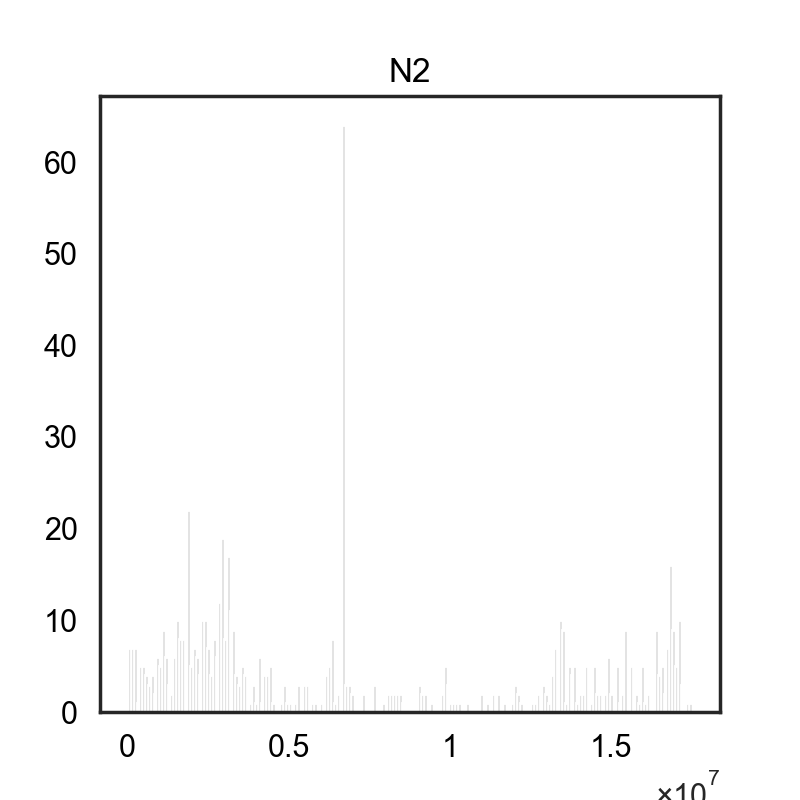

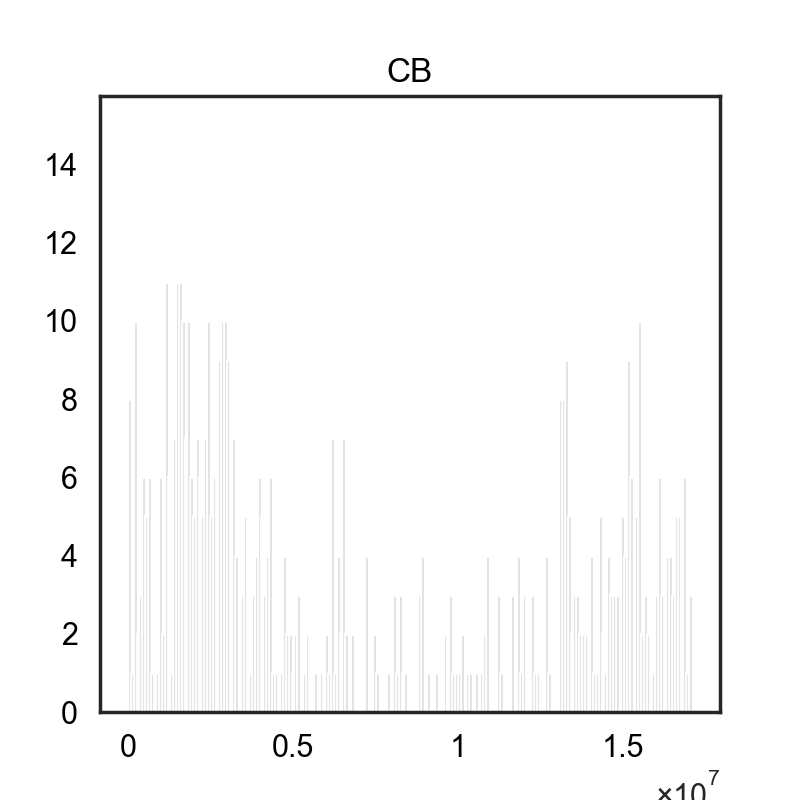

n2 max count 64.0
n2 max bin [6581870.875, 6669156.42]

cb max count 15.0
cb max bin [2997721.4499999997, 3083021.12]


In [92]:
spec_family = 'hAT'
chromosome = 'Chr IV' 

peak_tracker_list = track_down_hist_peaks(N2_all_df, CB_all_df, spec_family, chromosome)

n2_values = peak_tracker_list[0].tolist()
n2_bins = peak_tracker_list[1].tolist()

n2_max_value = (max(n2_values))
n2_max_value_index = (n2_values.index(n2_max_value))

n2_max_value_bin = n2_bins[n2_max_value_index-1:n2_max_value_index+1]
print('n2 max count', n2_max_value)
print('n2 max bin', n2_max_value_bin)

cb_values = peak_tracker_list[3].tolist()
cb_bins = peak_tracker_list[4].tolist()

cb_max_value = (max(cb_values))
cb_max_value_index = (cb_values.index(cb_max_value))

cb_max_value_bin = cb_bins[cb_max_value_index-1:cb_max_value_index+1]
print()
print('cb max count', cb_max_value)
print('cb max bin', cb_max_value_bin)


### 6.4.4. <a id='toc6_4_4_'></a>[FX: `make_every_fam_grid`](#toc0_)
- make plot of every single TE family distribution by chr in a huge grid
- columns: chromosome, rows: TE family
- x-axis: relative start position
- y-axis: count
- this is not a great looking graph, but can be helpful for getting an overview of the data

In [74]:
#N2 86abb1
#CB b0948f
# ,facet_kws=dict(sharex='col')
def make_every_fam_grid(df, genome: str, numbins: int, sharey: bool = False, to_save: bool = False):
    """  
    df: TE dataframe
    genome: str, name of the genome that will be inserted into the title
    numbins: int, number of equally sized bins the data will be divided into
    sharey: bool, whether or not the y-axis should be shared each individual histogram in the entire grid
    to_save: bool, whether or not to save the graph as a pdf (if False, graph will only be output into the notebook)

    """

    color = colors[genome]
    
    if sharey:
        shareystr = 'nosharey'
    else: 
        shareystr = 'sharey'
        
    g = sns.displot(data=df, x="Relative Start Position", col="Chromosome", row = 'Family', bins = numbins, kind="hist", color = color, edgecolor = color, facet_kws=dict(sharey=sharey))
    
    g.set_axis_labels("Relative Start Position", "Count")
    
    if to_save == True:  
        plt.savefig(f'{genome}_ultimate_byfamandchr_hist_{numbins}_LTRRet_{shareystr}.pdf', dpi=300, facecolor = 'w', edgecolor = 'w', format='pdf')

In [73]:
# make_every_fam_grid(N2_all_filter_df, 'N2', 100, sharey = False, to_save = False)

## 6.5. <a id='toc6_5_'></a>[TE COUNTS BAR GRAPH](#toc0_)
### 6.5.1. <a id='toc6_5_1_'></a>[FX: `make_te_counts_perfam`](#toc0_)
- creates a bar graph of the number of DNA and Retro elements (DNA in one graph, Retro in the second) in a given genome

In [78]:
def make_te_counts_perfam(strain: str, dna_tes, retro_tes, to_save: bool = False):
    """ 
    strain: str, name of the strain that will be used in the graph title and file name
    dna_tes: dna TEs dataframe
    retro_tes: retro TEs dataframe 
    to_save: bool, whether or not to save the graph as a pdf (if False, graph will only be output into the notebook)
    """
    
    sns.set(style="white")
        
    sns.set_palette(sns.color_palette(dna_color_list))

    fig, ax = plt.subplots(figsize=(12, 8))
    ax = sns.countplot(data = dna_tes, x = 'Family', order = dna_order)
    ax.set_ylabel("Count")
    for i in ax.containers:
        ax.bar_label(i,)
    plt.title(f'{strain} DNA TE counts per family')                                   

    if to_save == True:
    
        plt.savefig(f'{strain}_DNA_counts_all_LTRRet.pdf', dpi=300, facecolor = 'w', edgecolor = 'w', format='pdf')
    
    sns.set_palette(sns.color_palette(retro_color_list))

    fig, ax2 = plt.subplots(figsize=(12, 8))
    ax2 = sns.countplot(data = retro_tes, x = 'Family',  order = retro_order)
    ax2.set_ylabel("Count")
    for i in ax2.containers:
        ax2.bar_label(i,)
    plt.title(f'{strain} Retro-TE counts per family')                                   
    
    if to_save == True:
        
        plt.savefig(f'TEUlt_{strain}_retro_counts_all_LTRRet.pdf', dpi=300, facecolor = 'w', edgecolor = 'w', format='pdf')

In [83]:
# make_te_counts_perfam('N2', N2_dna_tes, N2_retro_tes, False)

below: runs the `make_te_counts_perfam` function on all genomes in the `strain_dict` list defined in the [graphing variables](#61-graphing-variables) cell

In [76]:
# for key, value in strain_dict.items():
#     dna_df = value[0]
#     retro_df = value[1]
#     make_te_counts_perfam(key, dna_df, retro_df)

### 6.5.2. <a id='toc6_5_2_'></a>[FX: `make_class_counts_allgenomes`](#toc0_)
- creates a paired bar graph style plot of the counts of either DNA or Retro elements for all genomes 

In [86]:
def make_class_counts_allgenomes(te_class: str, to_save: bool = False):
    """ 
    te_class: str, one of either 'retro' or 'dna'
    to_save: bool, whether or not to save the graph as a pdf (if False, graph will only be output into the notebook)
    """

    if te_class == 'retro':
        df = all_retro_tes
        title = 'Retro-'
        filestr = 'retro'
        order = retro_order
        
    elif te_class == 'dna':
        df = all_dna_tes
        title = 'DNA '
        filestr = 'dna'
        order = dna_order
    
    sns.set(style="white")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = sns.countplot(data = df, x = 'Family', order = order, hue='Strain', palette=colors)
    ax.set_ylabel("Count")
    for i in ax.containers:
        ax.bar_label(i, fontsize=7, label_type='edge')
    plt.title(f'{title}TE counts')   
    
    if to_save == True: 
        plt.savefig(f'{filestr}counts_allgenomes.pdf', dpi=300, facecolor = 'w', edgecolor = 'w', format='pdf')
    

In [88]:
# make_class_counts_allgenomes('dna', False)

## 6.6. <a id='toc6_6_'></a>[TE SIZES GRAPHS](#toc0_)
### 6.6.1. <a id='toc6_6_1_'></a>[boxplot of all sizes on one plot](#toc0_)
- this is not a great graph but can be helpful for getting an overview of the data

In [2]:
# sns.boxplot(x = 'Family', y = 'Size', data=N2_dna_tes)

### 6.6.2. <a id='toc6_6_2_'></a>[FX: `broken_axis_box` ](#toc0_)
- creates a broken axis boxplot of the TE sizes in either the DNA or Retro class
- used these links to make this fx:
    - https://gist.github.com/pfandzelter/0ae861f0dee1fb4fd1d11344e3f85c9e 
    - https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html

In [96]:
dna_order = ['Zator', 'hAT', 'CMC', 'Tc1-Mariner', 'Sola', 'Novosib', 'Helitron', 'MITE']
retro_order = ['Gypsy', 'Copia', 'LINE', 'SINE', 'ERV']

def broken_axis_box(data, genome: str, break_num: int, end_num: int, title: str, filename: str, order: list, showmeans: bool, to_save: bool = False):
    """ 
    data: TE dataframe
    genome: str, used in the title and filename
    break_num: int, number to break the axis at
    end_num: int, number to cap the y-axis at (can think of this as the y-limit)
    title: str, something like 'DNA ' or 'Retro' to indicate what class of TEs are being plotted
    filename: str, something like 'DNA ' or 'Retro' to indicate what class of TEs are being plotted
    order: list, what order to plot the families along the x-axis
    showmeans: bool, whether or not to include a red dot at the mean TE size of each family
    to_save: bool, whether or not to save the graph as a pdf (if False, graph will only be output into the notebook)
    """

    sns.set(style="whitegrid")
    pal = sns.color_palette('colorblind')

    f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize = (12, 8))
    flierprops = dict(marker='o', fillstyle = 'none')
    meanpointprops = dict(marker='D', markerfacecolor='red', markeredgecolor = 'black')


    ax1 = sns.boxplot(x = 'Family', y = 'Size', data=data, palette=pal, ax=ax1, order = order, fliersize = 5, flierprops = flierprops, showmeans = showmeans, meanprops=meanpointprops)
    ax2 = sns.boxplot(x = 'Family', y = 'Size', data=data, palette=pal, ax=ax2, order = order, fliersize = 5, flierprops = flierprops, showmeans = showmeans, meanprops=meanpointprops)

    ax1.set_ylim(break_num, end_num) # set y limits for both, if you want the scale to stay the same you have to have the same y range for both plots/axes
    ax2.set_ylim(0, break_num)

    ax1.get_xaxis().set_visible(False) # get rid of x axis for upper plot (it shares with the bottom one)

    ax1.set_ylabel("") # get rid of y labels for both
    ax2.set_ylabel("")
    f.text(0.05, 0.55, "Size of TE (bp)", va="center", rotation="vertical") # make ur own y label (diy🙂)

    # ax1.get_legend().remove() # get rid of automatic legends
    # ax2.get_legend().remove()
    # ax2.legend(loc=(1.025, 0.5), title="Design") # make ur own legend


    ax1.xaxis.tick_top()
    ax2.xaxis.tick_bottom()

    f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85, hspace=0.1)

    d = .01  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    ax1.title.set_text(f'Size Distributions of {genome} {title}TEs')
    # plt.legend()

    if to_save == True:
        plt.savefig(f'TEUlt_{genome}_{filename}_size_dist_broken_LTRRet.png', dpi=300, facecolor = 'w', edgecolor = 'w', format='png')

In [92]:
# broken_axis_box(N2_dna_tes, 'N2', 10000, 90000, 'DNA ', 'DNA', dna_order, True, False)

### 6.6.3. <a id='toc6_6_3_'></a>[FX: `make_boxplot`](#toc0_)
- make a boxplot of the TE sizes of TEs in a specific class (DNA or Retro) for one genome

In [94]:
dna_order = ['Zator', 'hAT', 'CMC', 'Tc1-Mariner', 'Sola', 'Novosib', 'Helitron', 'MITE']
retro_order = ['Gypsy', 'Copia', 'LINE', 'SINE', 'ERV']

def make_boxplot(dataframe, order: list, genome: str, title: str, color_palette: list, showmeans: bool, to_save: bool = False):
    """ 
    data: TE dataframe
    order: list, what order to plot the families along the x-axis
    genome: str, used in the title and filename
    title: str, something like 'DNA ' or 'Retro' to indicate what class of TEs are being plotted, used in the title and filename
    color_palette: list, list of colors defined in the define constant variables cell for each family
    showmeans: bool, whether or not to include a red dot at the mean TE size of each family
    to_save: bool, whether or not to save the graph as a pdf (if False, graph will only be output into the notebook)
    """

    sns.set_palette(sns.color_palette(color_palette))

    flierprops = dict(marker='o', fillstyle = 'none')
    meanpointprops = dict(marker='D', markerfacecolor='red', markeredgecolor = 'black')

    fig, axes = plt.subplots(figsize = (12,8))
    sns.boxplot(x = 'Family', y = 'Size', data=dataframe, ax = axes, order = order, fliersize = 5, flierprops = flierprops, showmeans = showmeans, meanprops=meanpointprops)

    # axes.legend(handles=handles)
    axes.title.set_text(f'Size Distributions of {genome} {title}TEs')

    if to_save == True:
        plt.savefig(f'TEUlt_{genome}_{title}_sizes_box.pdf', dpi=300, facecolor = 'w', edgecolor = 'w', format='pdf')

In [97]:
# make_boxplot(CB_all_filter_df, retro_order, 'CB', 'retro', retro_color_list, True, False)

### 6.6.4. <a id='toc6_6_4_'></a>[FX: `make_split_violin`](#toc0_)
- makes a split violin plot to compare the distribution of TE sizes by specific family between two genomes
- this function uses the seaborn violinplot function, so all of those parameters can be altered within the function

In [114]:
def make_split_violin(strain_one: str, strain_two: str, te_type: str, to_save: bool = False):
    """ 
    strain_one: str, name of the first strain to be compared, needs to be the exact string used to label genomes in your dataframes
    strain_two: str, name of the second strain to be compared, needs to be the exact string used to label genomes in your dataframes
    te_type: str, either 'dna' or 'retro', tells function what TE class to plot
    to_save: bool, whether or not to save the graph as a pdf (if False, graph will only be output into the notebook)
    """
 
    dataframe = all_filter_df[(all_filter_df['Strain'] == strain_one) | (all_filter_df['Strain'] == strain_two)]

    if te_type == 'dna':  
        order = dna_order
        
    
    elif te_type == 'retro':
        order = retro_order
        

    sns.set_style('white')

    fig, ax = plt.subplots(figsize = (13, 8))
    
    ax = sns.violinplot(x = 'Family', 
                       y = 'Size', 
                       data = dataframe, 
                       order = order, 
                       inner = 'quartile', 
                       linewidth = 1, 
                       scale='width', 
                       hue = 'Strain', 
                       split = True,
                       palette = colors,
                       cut=0,
                       alpha=1)
    
    ax.set_ylabel('Size', fontsize=18)
    ax.set_xlabel('Family', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left',fontsize=14)
    plt.tight_layout()

    if to_save:
        plt.savefig(f'{te_type}_violin_{strain_one}_{strain_two}.pdf', dpi=300, facecolor = 'w', edgecolor = 'w', format='pdf')


In [1]:
# make_split_violin('N2', 'CB', 'dna', False)

### 6.6.5. <a id='toc6_6_5_'></a>[FX: `make_box_allgen`](#toc0_)
- makes a paired box plot of the size distributions of a TE class for all genomes

In [116]:
def make_box_allgen(te_type: str, to_save: bool = False):
    """ 
    te_type: str, one of either 'dna' or 'retro', tells function what TE class to plot
    to_save: bool, whether or not to save the graph as a pdf (if False, graph will only be output into the notebook)
    """

    dataframe = all_filter_df

    if te_type == 'dna':  
        color_palette = dna_color_list
        order = dna_order
        title = 'DNA '
        filestr = 'dna'
    
    elif te_type == 'retro':
        color_palette = retro_color_list
        order = retro_order
        title = 'Retro-'
        filestr = 'retro'

    
    flierprops = dict(marker='o', fillstyle = 'none')
    meanpointprops = dict(marker='D', markerfacecolor='red', markeredgecolor = 'black')
    sns.set_palette(sns.color_palette(color_palette))

    fig, axes = plt.subplots(figsize = (12,8))
    sns.boxplot(x = 'Family', 
                y = 'Size', 
                hue = 'Strain',
                palette = colors,
                data=dataframe, 
                ax = axes, 
                order = order, 
                fliersize = 5, 
                flierprops = flierprops, 
                showmeans = True, 
                meanprops=meanpointprops)

    # axes.legend(handles=handles)
    axes.title.set_text(f'Size Distributions of {title}TEs')
    plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left',fontsize=14)
    plt.tight_layout()
    
    if to_save:
        plt.savefig(f'{filestr}_box_allgenomes.pdf', dpi=300, facecolor = 'w', edgecolor = 'w', format='pdf')

In [118]:
# make_box_allgen('dna', to_save = False)